# Assignment 2

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os
import pdb
import os


import sys

# Add the path to utils
sys.path.append('..')
from template import utils
from utils import plot_loss


In [27]:
# should be added into a utils file in the future
def set_seed():
    # Set a fixed random seed for reproducibility

    # Set the random seed for PyTorch
    torch.manual_seed(9001)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # If you are using CUDA, set the seed for CUDA as well

    if torch.cuda.is_available():
        torch.cuda.manual_seed(9001)

In [28]:
set_seed()

### Handling the data

In [29]:
# I am a big fan of config files and I believe it is a good practise
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])


config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [30]:
# may differ depending on the problem
transform = transforms.Compose(
    [transforms.ToTensor(),
     ]) # put more transforms options here

In [31]:
#load datasets (in the future it's possible that the whole process will be in a 
#separate file)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [33]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


### We can display some images from the dataset
Functions used will probably vastly differ from task to task

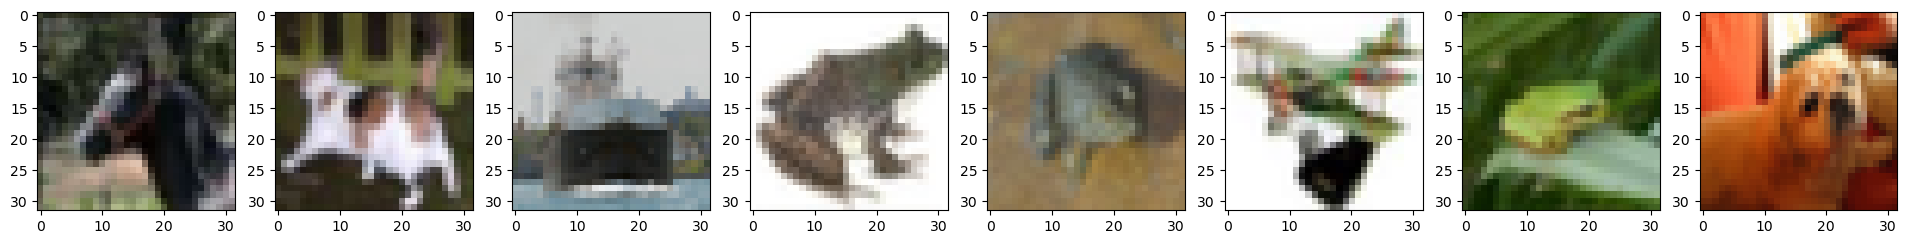

In [34]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,32,32).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

### Creating the model

In [35]:
class CNN(nn.Module):
    """ 
    Adapted to CIFAR-10
    """
    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        # (3,32,32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        # Layer 2
        # (64, 32, 32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # (64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        # (128, 16, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (128, 8, 8)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        # (256, 8, 8)
        
        # fully connected classifier
        in_dim = 256 * 8 * 8
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        out_flat = x.view(cur_b_size, -1)
        y = self.fc(out_flat)
        return y
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Training the model

In [36]:
from tqdm import tqdm

In [37]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

In [39]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training loop

In [40]:
# For saving models and checkpoints later
if(not os.path.exists("models")):
    os.makedirs("models")

In [41]:
train_loss_list = []
test_loss_list = []
test_accuracy_list = []
train_accuracy_list = []
# Initialize lists to store gradient information
gradients = []
gradient_norms = []
gradient_max_values = []
gradient_min_values = []
best_loss = 100
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))

    # Calculate test loss, accuracy for currently trained model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images_test, labels_test = data
            # using GPU for inference
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            # calculate model outputs
            outputs_test = model(images_test)
            # calculate test loss
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()
            # derive model predictions from out outputs
            predicted = torch.argmax(outputs_test, dim = -1)
            # calculate accuracy
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

        test_loss /= len(testloader)
        accuracy = 100 * correct / total

        print(f"test accuracy: {accuracy}%")

        # Potentially prevent overfitting
        if test_loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
        #saving the best checkpoint
        
    test_loss_list.append(test_loss)
    test_accuracy_list.append(accuracy)
    
    # Turn model back to training mode
    model.train()

    for i, (imgs, labels) in enumerate(progress_bar):

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0]

        train_accuracy_list.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list.append(loss.item())
        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

        '''In the following we calculate gradient information!'''
        
        # Calculate gradient information
        for name, param in model.named_parameters():
            # Tracking the matrices led to oom errors
            if name in ['layers.0.bias']:
                gradients.append(param.grad)
                gradient_norms.append(torch.norm(param.grad).item())
                gradient_max_values.append(param.grad.max().item())
                gradient_min_values.append(param.grad.min().item())

        '''Stop calculating gradient inforamtion'''
    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 8.96%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 59.29%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 65.97%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.31%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 71.8%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.53%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 73.6%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.79%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 74.93%


  0%|          | 0/782 [00:00<?, ?it/s]

test accuracy: 75.58%


Epoch 10 Iter 782: loss 0.35633. : 100%|██████████| 782/782 [00:03<00:00, 196.16it/s]


evaluating the model

In [42]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

 10%|▉         | 15/157 [00:00<00:00, 145.21it/s]

100%|██████████| 157/157 [00:00<00:00, 211.53it/s]

Test accuracy: 75.4%


### Just some first looks at the loss curves. Note, that the functions need to be overhauled

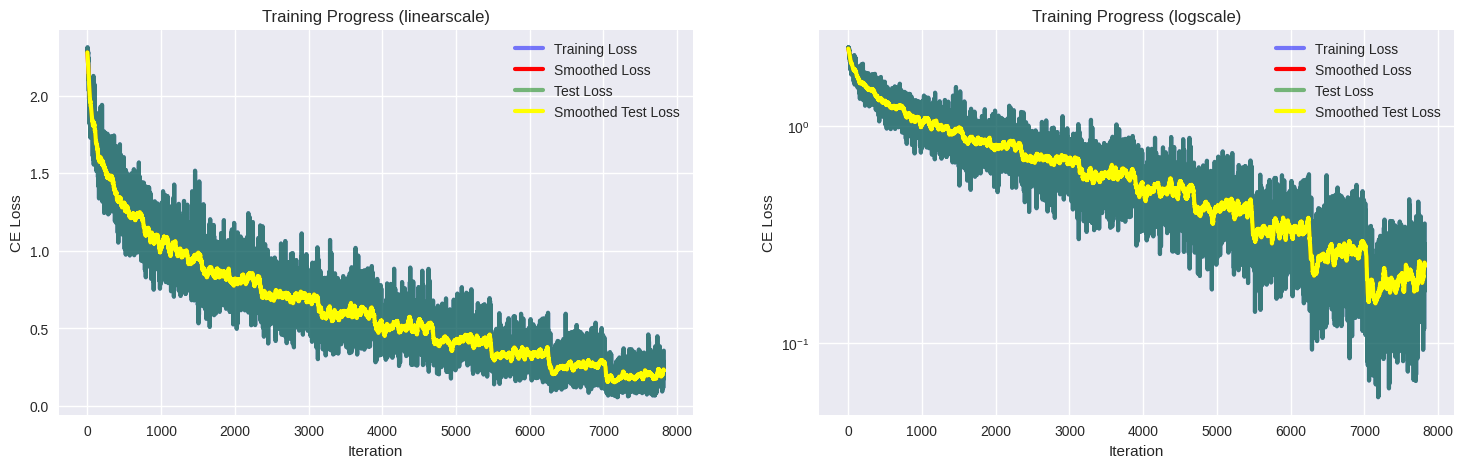

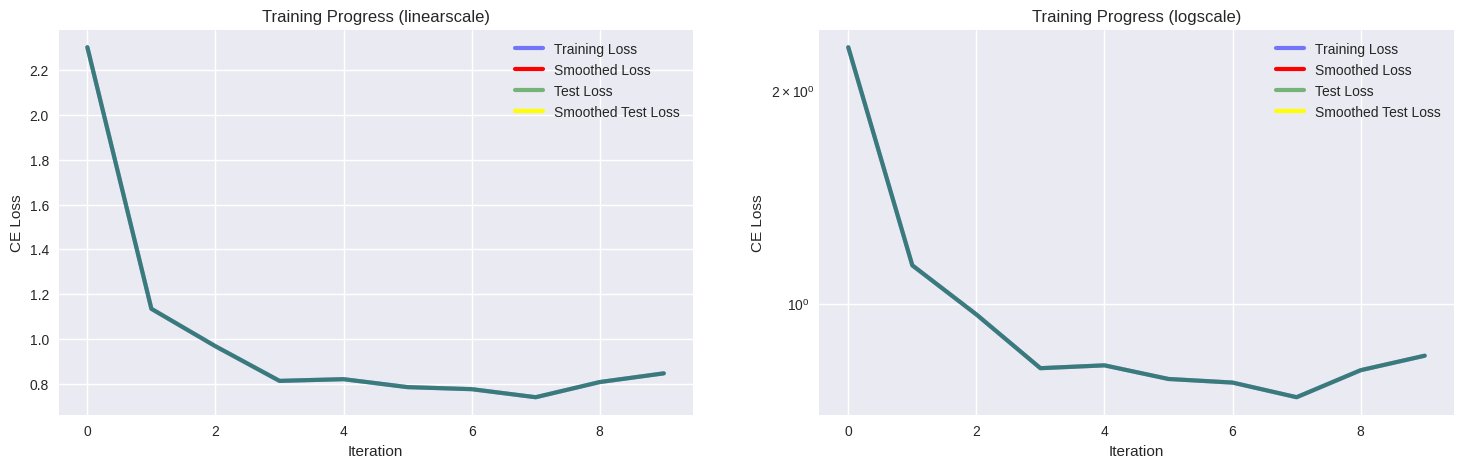

In [52]:
plot_loss(train_loss_list = train_loss_list, val_loss_list = train_loss_list)
plot_loss(train_loss_list=test_loss_list, val_loss_list=test_loss_list)

# Evaluation without hyperparameter optimization
Here we achieved an accuracy of 73.1%. We observe a significant increase from the MLP, which achieves an accuracy of around 50%. It is very likely, that the CNN makes better use of the spatial features of an image than the simple MLP. 

Next we want to "somewhat optimize" our hyperparameters using optuna

### Hyperparameter optimization using optuna

In [35]:
import optuna
from optuna.trial import TrialState

In [ ]:
def define_model(trial):
     

In [ ]:

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 128, log=True)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.7)

    # Define the model
    model = CNN()  # Replace with current model
    model.to(device)  # Move the model to GPU if available

    # Training Loop
    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(trainloader, total=len(trainloader))
        for i, (imgs, labels) in enumerate(progress_bar):

            # using GPU
            imgs, labels = imgs.to(device), labels.to(device)
        
            # forward pass
            preds = model(imgs)

            # calculate accuracy
            with torch.no_grad():
                predicted = preds.argmax(dim=-1)
                correct = (predicted == labels).sum().item()
                accuracy = correct/labels.shape[0]

            train_accuracy_list.append(accuracy)

            # computing error
            loss = criterion(preds, labels)
            train_loss_list.append(loss.item())
            # removing accumulated gradients
            optimizer.zero_grad()
        
            # backprogating error to compute gradients
            loss.backward()
        
            # updating parameters
            optimizer.step()
        
            if(i % 10 == 0 or i == len(trainloader) - 1):
                progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    return -accuracy  # Optuna minimizes, so we negate accuracy

# TODO: Define model

# Create a study and optimize
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    study = optuna.create_study(direction="maximize")  # maximize accuracy
    study.optimize(objective, n_trials=50)  # You can adjust the number of trials

    # Print the best hyperparameters
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



In [53]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []
    num_classes = 10
    input_dim = 32*32*3 #CIFAR10 image dims
    for i in range(n_layers):
        hidden_dim = trial.suggest_categorical("n_units_l{}".format(i), [512, 1024, 2048, 4096])
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        p = trial.suggest_categorical("dropout_l{}".format(i), [0, 0.1, 0.2]) #want to go easy on dropout, I fear that with - 
        layers.append(nn.Dropout(p)) # - high dropout, the model won't learn
        input_dim = hidden_dim
    layers.append(nn.Linear(input_dim, num_classes))

    return nn.Sequential(*layers)

In [54]:
#added for better visibility
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Objective function to be maximized (based on accuracy)

In [59]:
def objective(trial):

    # Generate the model.
    criterion = nn.CrossEntropyLoss()
    model = define_model(trial).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    model.train()
    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(trainloader, total=len(trainloader))
        for i, (imgs, labels) in enumerate(progress_bar):
            # comment these 2 lines if device=="cpu"
            labels = labels.to(device)
            imgs = imgs.to(device)
            # forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)

            # computing error
            loss = criterion(preds, labels)

            # removing accumulated gradients
            optimizer.zero_grad()
        
            # backprogating error to compute gradients
            loss.backward()
        
            # updating parameters
            optimizer.step()

    #evaluating the model
   # model.eval()
    n_correct = 0
    with torch.no_grad():
        progress_bar = tqdm(enumerate(testloader), total=len(testloader))
        for i, (imgs, labels) in progress_bar:
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)

            pred_labels = torch.argmax(preds, dim=-1)
            cur_correct = len(torch.where(pred_labels == labels)[0])
            n_correct = n_correct + cur_correct

    accuracy = n_correct / len(test_dataset) * 100
    print(accuracy)
    trial.report(accuracy, epoch)
        
    # prune some trials that are doomed to save time
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return accuracy #We could also maximize with respect to loss

In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

[I 2023-10-28 21:29:14,765] A new study created in memory with name: no-name-dfcec650-7210-4dcf-a18a-5ba351c94f38
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 297.86it/s]
[I 2023-10-28 21:29:42,494] Trial 0 finished with value: 46.89 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout_l0': 0.2}. Best is trial 0 with value: 46.89.


46.89


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 308.24it/s]
[I 2023-10-28 21:30:15,536] Trial 1 finished with value: 49.769999999999996 and parameters: {'n_layers': 2, 'n_units_l0': 4096, 'dropout_l0': 0.2, 'n_units_l1': 1024, 'dropout_l1': 0}. Best is trial 1 with value: 49.769999999999996.


49.769999999999996


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 300.54it/s]
[I 2023-10-28 21:30:42,743] Trial 2 finished with value: 46.77 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout_l0': 0.2}. Best is trial 1 with value: 49.769999999999996.


46.77


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 275.11it/s]
[I 2023-10-28 21:31:14,455] Trial 3 finished with value: 43.769999999999996 and parameters: {'n_layers': 4, 'n_units_l0': 512, 'dropout_l0': 0.2, 'n_units_l1': 1024, 'dropout_l1': 0.2, 'n_units_l2': 2048, 'dropout_l2': 0.1, 'n_units_l3': 4096, 'dropout_l3': 0.1}. Best is trial 1 with value: 49.769999999999996.


43.769999999999996


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 233.40it/s]
[I 2023-10-28 21:31:43,902] Trial 4 finished with value: 47.54 and parameters: {'n_layers': 1, 'n_units_l0': 2048, 'dropout_l0': 0.2}. Best is trial 1 with value: 49.769999999999996.


47.54


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 253.05it/s]
[I 2023-10-28 21:32:14,148] Trial 5 pruned. 


39.72


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 216.65it/s]
[I 2023-10-28 21:32:45,422] Trial 6 finished with value: 50.22 and parameters: {'n_layers': 4, 'n_units_l0': 512, 'dropout_l0': 0, 'n_units_l1': 2048, 'dropout_l1': 0, 'n_units_l2': 512, 'dropout_l2': 0.2, 'n_units_l3': 1024, 'dropout_l3': 0.2}. Best is trial 6 with value: 50.22.


50.22


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 282.26it/s]
[I 2023-10-28 21:33:14,700] Trial 7 finished with value: 48.24 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'dropout_l0': 0.2, 'n_units_l1': 2048, 'dropout_l1': 0.1}. Best is trial 6 with value: 50.22.


48.24


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 300.96it/s]
[I 2023-10-28 21:33:51,894] Trial 8 pruned. 


47.24


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 227.94it/s]
[I 2023-10-28 21:34:43,898] Trial 9 finished with value: 50.849999999999994 and parameters: {'n_layers': 4, 'n_units_l0': 1024, 'dropout_l0': 0, 'n_units_l1': 1024, 'dropout_l1': 0, 'n_units_l2': 4096, 'dropout_l2': 0, 'n_units_l3': 4096, 'dropout_l3': 0.2}. Best is trial 9 with value: 50.849999999999994.


50.849999999999994


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 291.83it/s]
[I 2023-10-28 21:35:14,615] Trial 10 finished with value: 50.480000000000004 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'dropout_l0': 0, 'n_units_l1': 512, 'dropout_l1': 0.2, 'n_units_l2': 4096, 'dropout_l2': 0}. Best is trial 9 with value: 50.849999999999994.


50.480000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 270.59it/s]
[I 2023-10-28 21:35:46,100] Trial 11 finished with value: 51.519999999999996 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'dropout_l0': 0, 'n_units_l1': 512, 'dropout_l1': 0.2, 'n_units_l2': 4096, 'dropout_l2': 0}. Best is trial 11 with value: 51.519999999999996.


51.519999999999996


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 278.69it/s]
[I 2023-10-28 21:36:16,253] Trial 12 finished with value: 50.43 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'dropout_l0': 0, 'n_units_l1': 512, 'dropout_l1': 0.2, 'n_units_l2': 4096, 'dropout_l2': 0}. Best is trial 11 with value: 51.519999999999996.


50.43


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 253.91it/s]
[I 2023-10-28 21:36:46,452] Trial 13 pruned. 


49.46


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 277.57it/s]
[I 2023-10-28 21:37:18,006] Trial 14 finished with value: 52.31 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'dropout_l0': 0, 'n_units_l1': 1024, 'dropout_l1': 0, 'n_units_l2': 1024, 'dropout_l2': 0}. Best is trial 14 with value: 52.31.


52.31


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 259.87it/s]
[I 2023-10-28 21:38:23,664] Trial 15 finished with value: 51.55 and parameters: {'n_layers': 3, 'n_units_l0': 4096, 'dropout_l0': 0, 'n_units_l1': 4096, 'dropout_l1': 0.2, 'n_units_l2': 1024, 'dropout_l2': 0}. Best is trial 14 with value: 52.31.


51.55


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 282.51it/s]
[I 2023-10-28 21:39:21,524] Trial 16 finished with value: 50.49 and parameters: {'n_layers': 2, 'n_units_l0': 4096, 'dropout_l0': 0.1, 'n_units_l1': 4096, 'dropout_l1': 0.2}. Best is trial 14 with value: 52.31.


50.49
Study statistics: 
  Number of finished trials:  17
  Number of pruned trials:  3
  Number of complete trials:  14
Best trial:
  Value:  52.31
  Params: 
n_layers: 3
n_units_l0: 1024
dropout_l0: 0
n_units_l1: 1024
dropout_l1: 0
n_units_l2: 1024
dropout_l2: 0


Thanks to plot_slice method, we can match each of the optimized parameters against objective value (accuracy). That way we can actually see, which hyperparameters are more importants than others.

/tmp/ipykernel_2046632/4078749042.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig_4 = optuna.visualization.matplotlib.plot_slice(study)


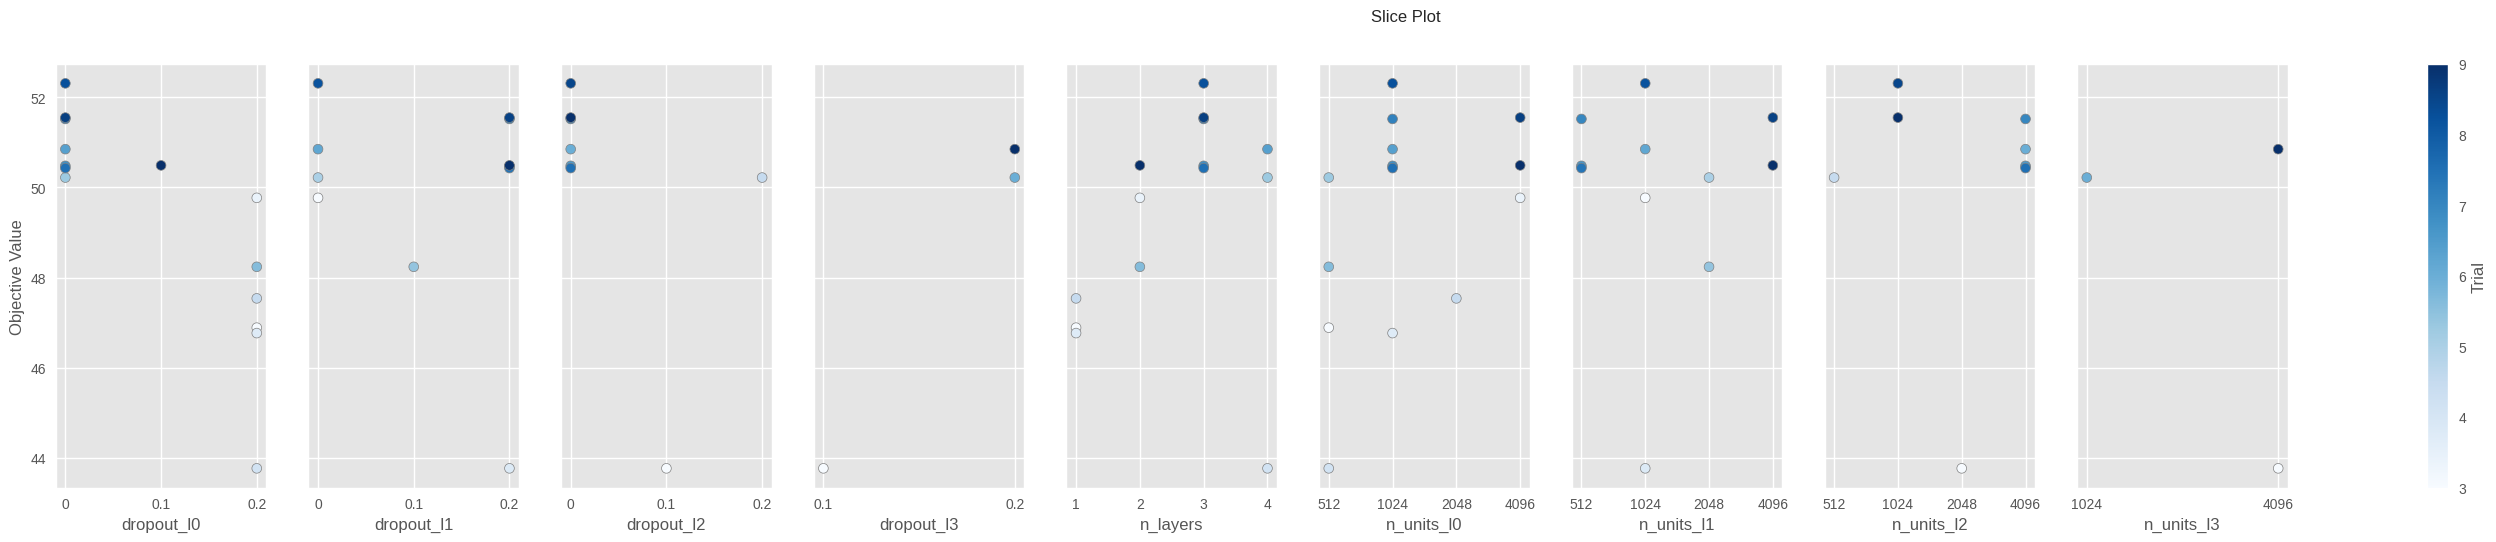

In [61]:
#visualizing plots (we will discuss them later)
# fig_2 = optuna.visualization.matplotlib.plot_param_importances(study)
# fig_3 = optuna.visualization.matplotlib.plot_contour(study)
fig_4 = optuna.visualization.matplotlib.plot_slice(study)

We can see the specified hyperparameters individually. From the first glance one can see what values of hyperparameters are "better". For example, when it comes to dropout, it is noticable that no dropout (=0) achieved better results. We can also look at each of the plots individually. Let's take a closer look at the n_layers hyperparameter plot.

/tmp/ipykernel_2046632/1037203267.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig_4 = optuna.visualization.matplotlib.plot_slice(study, params=["n_layers"])


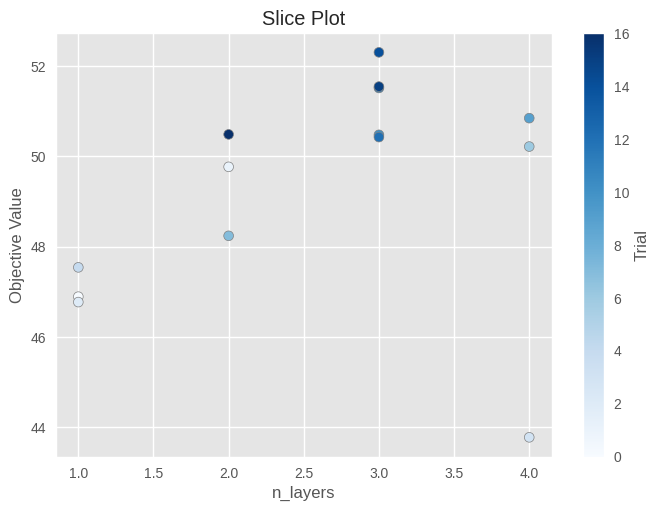

In [62]:
fig_4 = optuna.visualization.matplotlib.plot_slice(study, params=["n_layers"])

This study showed that higher number of layers is more preferable.  

It is also possible to match hyperparameters against each other in order to get the best combination of them with relation to objective value.

/tmp/ipykernel_2046632/3723222630.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=["dropout_l0", "n_units_l0"])
[W 2023-10-28 22:04:47,116] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


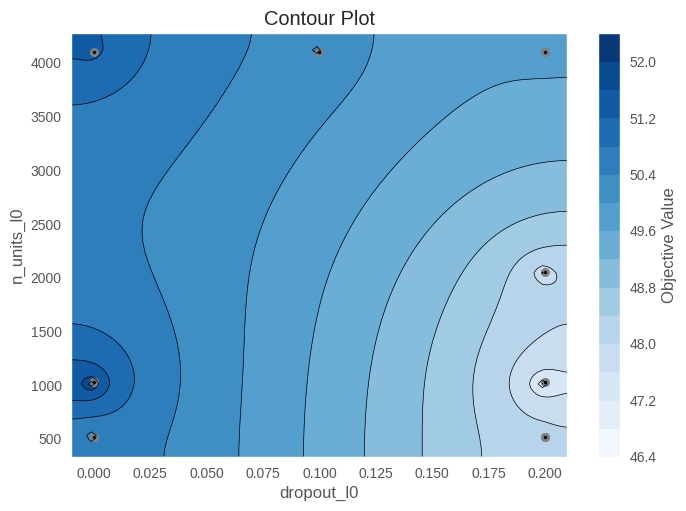

In [63]:
fig = optuna.visualization.matplotlib.plot_contour(study, params=["dropout_l0", "n_units_l0"])

The above plot shows that best combination of dropout and number of units (hidden dim) in layer 0 is: dropout = 0 and n_units = 1024. This allowed the model to reach accuracy equal to about 53%.

In the end, we can show a general history optimalization plot.

/tmp/ipykernel_2046632/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

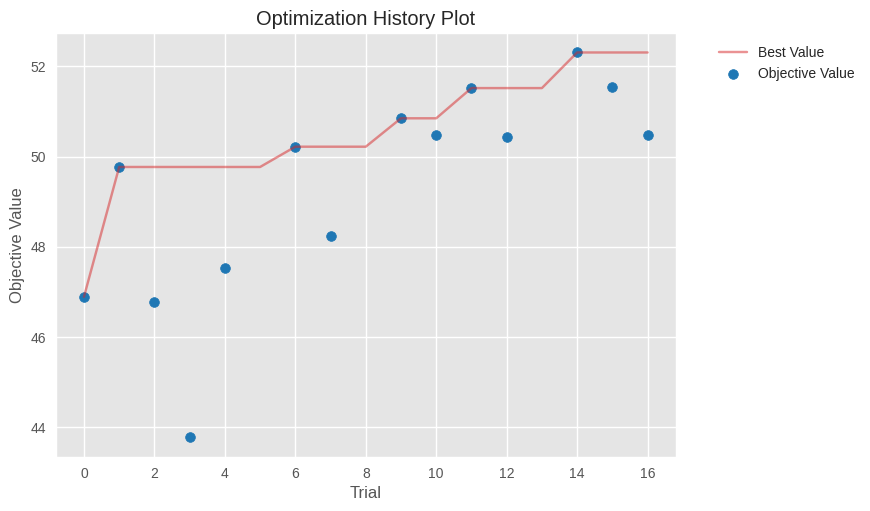

In [64]:
optuna.visualization.matplotlib.plot_optimization_history(study)

### Conclusions
We successfully utilized optuna to search for a correct hyperparamether values. Model achieved higher accuracy thanks to optuna optimization. Best hyperparameter combination and their values are shown below. We can also speculate, that if we set up a higher number of trials in the optuna study, we would be able to achieve a higher accuracy. After all, the plot optimization history plot has a growing trend

In [65]:
study.best_params

{'n_layers': 3,
 'n_units_l0': 1024,
 'dropout_l0': 0,
 'n_units_l1': 1024,
 'dropout_l1': 0,
 'n_units_l2': 1024,
 'dropout_l2': 0}

# Bonus Task: MLP Mixer


In [25]:

class MLPBlock(nn.Module):
    '''
    Parameters:
         dim: int
         Input and Output dimension of the entire block
         hidden_dim: int
         hidden layer dimension
    '''
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.linear_1 = nn.Linear(dim, hidden_dim)
        self.activation = nn.GELU()
        self.linear_2 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        '''

        :param x: torch.tensor
        Input tensor of shape (batch, n_channels, n_patches)
        :return: torch.tensor, which has the shape (batch, n_channels, n_patches)
        '''
        # print(x.shape)
        x = self.linear_1(x)
        x = self.activation(x)
        x = self.linear_2(x)

        return x


class MixerBlock(nn.Module):
    '''Parameters:
           n_patches : int
           hidden_dim: int
           This was the C value in the paper, the dimension which we project out patches to
           tokens_mlp_dim : int
           Hidden dimension for doing token-mixing
           channels_mlp_dim: int
           Hidden dimension for doing channel mixing
   '''


    def __init__(self, *, n_patches, hidden_dim, token_mlp_dim, channels_mlp_dim):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)

        self.token_mlp_block = MLPBlock(n_patches, token_mlp_dim)
        self.channel_mlp_block = MLPBlock(hidden_dim, channels_mlp_dim)

    def forward(self, x):
        '''
        :param x: torch.Tensor
        It is of shape (batch_size, n_patches, hidden_dim)
        :return: torch. Tensor
        Shape: (batch_size, n_patches, hidden_dim)
        '''
        # Separate y, because we need x as a residual connection
        y = self.norm_1(x)  # (batch, n_patches, hidden_dim)
        # 3d pytorch inputs takes the last dim, i.e. the row, therefore we need to transpose
        y = y.permute(0, 2, 1)  # (batch_size, hidden_dim, n_patches)
        y = self.token_mlp_block(y)  # (batch_size, hidden_dim, n_patches)
        y = y.permute(0, 2, 1)  # (batch_size, n_patches, hidden_dim)
        x = x + y  # (batch_size, n_patches, hidden_dim)
        y = self.norm_2(x)
        res = x + self.channel_mlp_block(y)  # (batch_size, n_patches, hidden_dim)

        return res




class MLPMixer(nn.Module):
    """
    sticking all parts together

    Parameters:
        image_size: int (We assume squares due to us focussing on CIFAR)
            Height and width of the input image
        patch_size: int
            Height and width of the square patches
        tokens_mlp_dim: int
            Hidden Dim for token mixer MLP
        channels_mlp_dim: int
            Hidden dim for MLPBlock when doing the channel mixing
        n_classes : int
            Number of classes for classification
        hidden_dim : int
            dim of patch embeddings
        n_blocks : int
            number of mixerblocks in the architecture
    """

    def __init__(self, *, image_size, patch_size, tokens_mlp_dim, channels_mlp_dim, n_classes, hidden_dim, n_blocks):
        super().__init__()
        n_patches = (image_size // patch_size) ** 2  # assume divisibility

        self.patch_embedder = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)

        self.blocks = nn.ModuleList([MixerBlock(
            n_patches=n_patches,
            hidden_dim = hidden_dim,
            token_mlp_dim=tokens_mlp_dim,
            channels_mlp_dim = channels_mlp_dim
        ) for _ in range(n_blocks)])

        self.pre_head_norm = nn.LayerNorm(hidden_dim)
        self.head_classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        '''Parameters:
        x : torch. Tensor
            Input batch of square images of shape (batch_size, n_channels, image_size, images_size)

        :returns torch. Tensor
            class logits of shape (batch_size, n_classes)
        '''

        x = self.patch_embedder(x) # (batch_size, hidden_dim, n_patches**0.5, n_patches**0.5)
        x = einops.rearrange(x, "n c h w -> n (h w) c") # (batch, n_patches, hidden_dim)


        for mixer_block in self.blocks:
            x = mixer_block(x)  # (batch, n_patches, hidden_dim)


        x = self.pre_head_norm(x)  # (batch_size, n_patches, hidden_dim)
        x = x.mean(dim=1)  # (batch, hidden_dim)
        y = self.head_classifier(x)  # (batch, n_classes)
        return y

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPMixer(image_size=32, patch_size=4, tokens_mlp_dim=2048, channels_mlp_dim=256,
                    n_classes=10, hidden_dim = 512, n_blocks=8)
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# needed for calculating the patches
import einops

In [28]:
train_loss_list = []
train_accuracy_list = []
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(trainloader, total=len(trainloader))
    for i, (imgs, labels) in enumerate(progress_bar):

        # Turn model back to training mode
        model.train()

        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        preds = model(imgs)

        # calculate accuracy
        with torch.no_grad():
            predicted = preds.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0]

        train_accuracy_list.append(accuracy)

        # computing error
        loss = criterion(preds, labels)
        train_loss_list.append(loss.item())


        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating parameters
        optimizer.step()

    
        if(i % 10 == 0 or i == len(trainloader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 10 Iter 782: loss 0.19899. : 100%|██████████| 782/782 [00:46<00:00, 16.97it/s]


In [29]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (imgs, labels) in progress_bar:
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(imgs)

        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct


accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 157/157 [00:03<00:00, 40.73it/s]

Test accuracy: 64.19%


# Evaluation: MLP Mixer

Due to time constraints, we will unfortunately not be able to optimize our hyperparameters further. The ones we used were taken straight from the paper. Due to time constraints we are also not able to pre-train our model.

The MLP Mixer achieved an accuracy of 64.19% on the test set, which was better than the accuracy achieved on the MLP, even after hyperparameter optimization. A reason for this could be the better designed network. It could for instance be possible that, due to the splitting of the images into patches and then connecting the individual patches with each other, we make more use of the spatial information given to us by the data. In addition, we used some simple but more modern techniques like residual connections, which facilitate training of neural networks.

Nevertheless, we do not consider this a complete sucess. We believe, that with sufficient pre-training and hyperparameter optimization higher accuracies can be achieved.